<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imitation-learning" data-toc-modified-id="Imitation-learning-1">Imitation learning</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Creating-the-environment" data-toc-modified-id="Creating-the-environment-1.2">Creating the environment</a></span></li><li><span><a href="#Playing-strategy" data-toc-modified-id="Playing-strategy-1.3">Playing strategy</a></span><ul class="toc-item"><li><span><a href="#1.-Food" data-toc-modified-id="1.-Food-1.3.1">1. Food</a></span></li><li><span><a href="#2.-Preferences" data-toc-modified-id="2.-Preferences-1.3.2">2. Preferences</a></span></li><li><span><a href="#3.-Obstacles" data-toc-modified-id="3.-Obstacles-1.3.3">3. Obstacles</a></span></li><li><span><a href="#4.-Avoidance" data-toc-modified-id="4.-Avoidance-1.3.4">4. Avoidance</a></span></li></ul></li><li><span><a href="#Learning-from-recorded-games" data-toc-modified-id="Learning-from-recorded-games-1.4">Learning from recorded games</a></span><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.4.1">Preparing the data</a></span></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.4.2">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Problems-with-conda-environment" data-toc-modified-id="Problems-with-conda-environment-1.4.2.1">Problems with conda environment</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.4.2.2">Building the model</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.4.3">Train</a></span></li></ul></li><li><span><a href="#Visualizing-agent-play" data-toc-modified-id="Visualizing-agent-play-1.5">Visualizing agent play</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li></ul></li></ul></div>

# Imitation learning

On this notebook I want to improve the results from the previous notebook by training on more levels. I will also apply mirroring to duplicate game data.

## Imports

In [92]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Creating the environment

In [2]:
env = UnityEnvironment(
    file_name='/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/env/AnimalAI.x86_64',   # Path to the environment
    worker_id=0,                # Unique ID for running the environment (used for connection)
    seed=0,                     # The random seed 
    docker_training=False,      # Whether or not you are training inside a docker
    n_arenas=1,                 # Number of arenas in your environment
    play=False,                 # Set to False for training
    inference=False,            # Set to true to watch your agent in action
    resolution=None             # Int: resolution of the agent's square camera (in [4,512], default 84)
)

In [3]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7f79ab51c780>}

In [4]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food_small.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7f79ab51c8d0>}

## Playing strategy

* I'm going to try to play as natural as possible and as good as possible. If I make mistakes I will try to discard those games.
* I won't be giving preference to any rotation side, because mirror solves that problem. I will try to use the more natural way.

https://mdcrosby.com/blog/animalailaunch.html  
https://mdcrosby.com/blog/animalaieval.html

### 1. Food

* fixed food
* fixed small food
* moving food
* moving small food
* fixed multifood
* moving multifood

### 2. Preferences

* food, bad, multi
* same but moving
* 2-Preferences_1good_6bad, to learn to avoid bad goals

### 3. Obstacles

* good, 2 walls. Sometimes we have to explore the environment to reach the goal

### 4. Avoidance

* good, dead zone
* 4-Avoidance_3dead, very difficult to create viable scenarios
* 4-Avoidance_3deadsmall
* 4-Avoidance_6deadsmall
* 4-Avoidance_9deadsmall

* 5-SpatialReasoning
* 6-Generalization
* objectManipulation

## Learning from recorded games

### Preparing the data

In [64]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate(previous_action, axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0]/10,
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output

In [65]:
def mirror_game(game_data):
    return _mirror_input_data(game_data[0]), _mirror_output_data(game_data[1])
    
def _mirror_input_data(input_data):
    mirror_input_data = input_data.copy()
    mirror_input_data['frame'] = np.flip(mirror_input_data['frame'], axis=2)
    mirror_input_data['previous_action'] = mirror_input_data['previous_action'][:, [0, 1, 2, 3, 5, 4]]
    return mirror_input_data

def _mirror_output_data(output_data):
    mirror_output_data = output_data.copy()
    mirror_output_data['action_rotate'] = mirror_output_data['action_rotate'][:, [0, 2, 1]]
    return mirror_output_data

In [66]:
def duplicate_games(game_data):
    mirror_game_data = mirror_game(game_data)
    input_data, output_data = {}, {}
    for key in game_data[0]:
        input_data[key] = np.concatenate([game_data[0][key], mirror_game_data[0][key]], axis=0)
    for key in game_data[1]:
        output_data[key] = np.concatenate([game_data[1][key], mirror_game_data[1][key]], axis=0)
    return input_data, output_data

In [81]:
game_filepaths = sorted(glob.glob('/media/guillermo/Data/Kaggle/animalai/gameplay/*/*.npz'))
np.random.seed(7)
np.random.shuffle(game_filepaths)
len(game_filepaths)

562

In [8]:
model_input, model_output = load_games_data(game_filepaths)
input_keys = ['frame', 'speed', 'previous_action']
output_keys = ['action_move', 'action_rotate']
print('Inputs')
for key in input_keys:
    print('%s shape: %s' % (key, str(model_input[key].shape)))
print('Outputs')
for key in output_keys:
    print('%s shape: %s' % (key, str(model_output[key].shape)))


Inputs
frame shape: (7442, 84, 84, 3)
speed shape: (7442, 3)
previous_action shape: (7442, 6)
Outputs
action_move shape: (7442, 3)
action_rotate shape: (7442, 3)


In [82]:
train = load_games_data(game_filepaths[:-int(len(game_filepaths)//5)])
val = load_games_data(game_filepaths[-int(len(game_filepaths)//5):])

train = duplicate_games(train)
val = duplicate_games(val)

print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 60822
Number of validation samples: 13934


### Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

#### Problems with conda environment

There are inconsistencies between opencv, tensorflow-gpu and the environment requirements (numpy 1.14.5). Maybe I should create an environment for playing an another for training. However if I want to do reinforcement learning I need both in the environment.

Which are my requirements:
* python 3.6, this is required by animalai
* opencv 4.1.0 or higher, previous versions do not show the window
* tensorflow-gpu, needed to train
* numpy 1.14.5, is this really necessary?

I think the problem is that there are conflicts between them.

Ideas:
* I could try to create an environment from zero
* Why numpy 1.14.5 is needed?

Let's try to use a higher version of numpy on animalai. I can revert to other versions of the environment following the link below.

http://blog.rtwilson.com/conda-revisions-letting-you-rollback-to-a-previous-version-of-your-environment/

I have been able to remove numpy 1.14.5 and install numpy 1.16.1 and the environment runs.

I have created a new environment called animal that seems to be working. The steps were the following:

```
conda create -n animal python=3.6
conda activate animal
pip install animalai
pip uninstall numpy
conda install -c conda-forge tensorflow-gpu opencv==4.1.0
conda install jupyter ipywidgets
python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "Python ($CONDA_DEFAULT_ENV)"
conda install pytest rope pylint tqdm pandas scikit-learn ipython ipykernel autopep8 matplotlib
```

#### Building the model

In [68]:
def build_model(conv_filters, mlp_units):
    frame = Input(shape=(84, 84, 3), name='frame')
    output = frame
    for n_filters in conv_filters:
        output = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu')(output)
        output = MaxPool2D()(output)
    output = Flatten()(output)
    
    speed = Input(shape=(3), name='speed')
    previous_action = Input(shape=(6), name='previous_action')
    
    output = Concatenate()([output, speed, previous_action])
    
    for n_units in mlp_units:
        output = Dense(n_units, activation='relu')(output)
    
    action_move = Dense(3, activation='softmax', name='action_move')(output)
    action_rotate = Dense(3, activation='softmax', name='action_rotate')(output)
    
    model = Model(inputs=dict(frame=frame, speed=speed, previous_action=previous_action), outputs=[action_move, action_rotate])
    return model

In [68]:
model = build_model([8, 8, 16, 16], [16])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 39, 39, 8)    584         max_pooling2d_24[0][0]           
____________________________________________________________________________________________

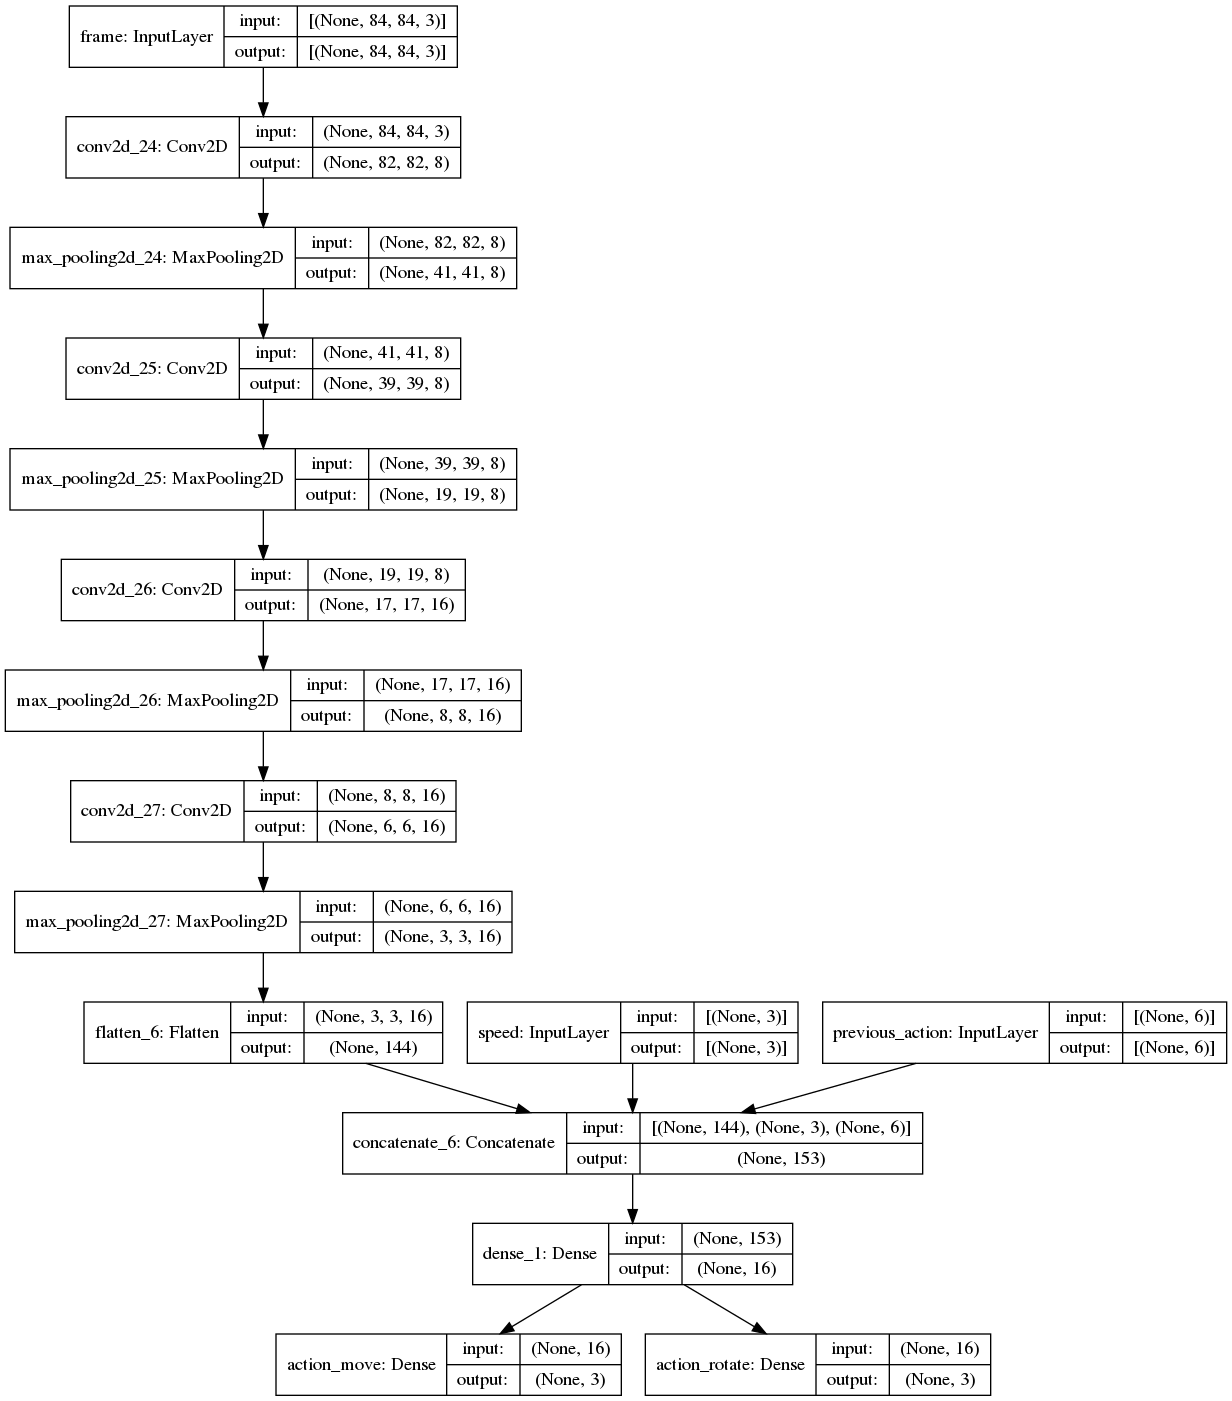

In [69]:
plot_model(model, show_shapes=True)

In [21]:
train[0]['frame'].shape

(2806, 84, 84, 3)

In [27]:
model.predict(train[0], batch_size=32, verbose=1)

2806/2806 [==============================] - 0s 93us/sample


[array([[0.3731478 , 0.30699477, 0.31985748],
        [0.35981053, 0.35984838, 0.28034103],
        [0.37141642, 0.3486689 , 0.2799147 ],
        ...,
        [0.40580714, 0.00190342, 0.5922895 ],
        [0.40458828, 0.00183663, 0.59357506],
        [0.39020362, 0.00169898, 0.60809743]], dtype=float32),
 array([[2.9629123e-01, 3.4093401e-01, 3.6277470e-01],
        [3.1343883e-01, 3.3088651e-01, 3.5567465e-01],
        [3.0650663e-01, 3.3603188e-01, 3.5746148e-01],
        ...,
        [6.7303479e-02, 8.5454324e-04, 9.3184197e-01],
        [6.7455359e-02, 8.0940087e-04, 9.3173522e-01],
        [6.8677425e-02, 7.7946781e-04, 9.3054312e-01]], dtype=float32)]

This is very fast, it should train very fast also.

### Train

In [88]:
def train_model(conv_filters, mlp_units):
    model = build_model(conv_filters, mlp_units)
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', patience=2, factor=0.7, verbose=1)
    ]
    hist = model.fit(x=train[0], y=train[1], epochs=500, validation_data=val, callbacks=callbacks)
    plot_hist(hist.history)
    return model
    
def plot_hist(hist):
    plt.figure()
    keys = ['loss']
    for key in keys:
        for prefix in ['', 'val_']:
            label = '%s%s' % (prefix, key)
            best_score = np.min(hist[label])
            plt.plot(hist[label], label='%s %.4f' % (label, best_score))
    plt.legend(loc=0)

Train on 60822 samples, validate on 13934 samples
Epoch 1/500
60822/60822 [==============================] - 14s 224us/sample - loss: 0.7866 - action_move_loss: 0.3423 - action_rotate_loss: 0.4442 - action_move_acc: 0.8782 - action_rotate_acc: 0.8637 - val_loss: 0.6122 - val_action_move_loss: 0.2900 - val_action_rotate_loss: 0.3226 - val_action_move_acc: 0.8997 - val_action_rotate_acc: 0.8932
Epoch 2/500
60822/60822 [==============================] - 13s 213us/sample - loss: 0.6481 - action_move_loss: 0.3009 - action_rotate_loss: 0.3472 - action_move_acc: 0.8852 - action_rotate_acc: 0.8838 - val_loss: 0.5536 - val_action_move_loss: 0.2575 - val_action_rotate_loss: 0.2963 - val_action_move_acc: 0.9012 - val_action_rotate_acc: 0.8964
Epoch 3/500
60822/60822 [==============================] - 13s 221us/sample - loss: 0.6163 - action_move_loss: 0.2828 - action_rotate_loss: 0.3335 - action_move_acc: 0.8913 - action_rotate_acc: 0.8875 - val_loss: 0.5440 - val_action_move_loss: 0.2512 - val_a

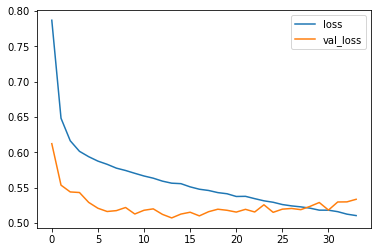

In [85]:
model = train_model([8, 8, 16, 16], [16])
model.save('model_small.hdf')

Train on 60822 samples, validate on 13934 samples
Epoch 1/500
60822/60822 [==============================] - 16s 258us/sample - loss: 0.7841 - action_move_loss: 0.3476 - action_rotate_loss: 0.4365 - action_move_acc: 0.8720 - action_rotate_acc: 0.8496 - val_loss: 0.5872 - val_action_move_loss: 0.2740 - val_action_rotate_loss: 0.3131 - val_action_move_acc: 0.8983 - val_action_rotate_acc: 0.8955
Epoch 2/500
60822/60822 [==============================] - 16s 256us/sample - loss: 0.6258 - action_move_loss: 0.2873 - action_rotate_loss: 0.3385 - action_move_acc: 0.8927 - action_rotate_acc: 0.8874 - val_loss: 0.5452 - val_action_move_loss: 0.2500 - val_action_rotate_loss: 0.2949 - val_action_move_acc: 0.9071 - val_action_rotate_acc: 0.9006
Epoch 3/500
60822/60822 [==============================] - 16s 256us/sample - loss: 0.6022 - action_move_loss: 0.2758 - action_rotate_loss: 0.3264 - action_move_acc: 0.8952 - action_rotate_acc: 0.8889 - val_loss: 0.5459 - val_action_move_loss: 0.2522 - val_a

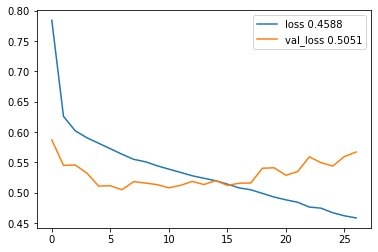

In [89]:
model = train_model([16, 16, 32, 32], [16, 16])
model.save('model_medium.hdf')

Train on 60822 samples, validate on 13934 samples
Epoch 1/500
60822/60822 [==============================] - 17s 287us/sample - loss: 0.7275 - action_move_loss: 0.3164 - action_rotate_loss: 0.4110 - action_move_acc: 0.8826 - action_rotate_acc: 0.8640 - val_loss: 0.5755 - val_action_move_loss: 0.2642 - val_action_rotate_loss: 0.3107 - val_action_move_acc: 0.9046 - val_action_rotate_acc: 0.8981
Epoch 2/500
60822/60822 [==============================] - 16s 260us/sample - loss: 0.6099 - action_move_loss: 0.2783 - action_rotate_loss: 0.3316 - action_move_acc: 0.8949 - action_rotate_acc: 0.8878 - val_loss: 0.5414 - val_action_move_loss: 0.2482 - val_action_rotate_loss: 0.2931 - val_action_move_acc: 0.9079 - val_action_rotate_acc: 0.8992
Epoch 3/500
60822/60822 [==============================] - 16s 258us/sample - loss: 0.5924 - action_move_loss: 0.2701 - action_rotate_loss: 0.3224 - action_move_acc: 0.8979 - action_rotate_acc: 0.8904 - val_loss: 0.5412 - val_action_move_loss: 0.2483 - val_a

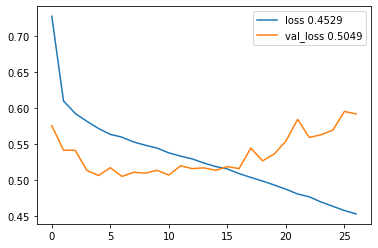

In [90]:
model = train_model([16, 32, 64, 32], [16, 32])
model.save('model_other.hdf')

Train on 60822 samples, validate on 13934 samples
Epoch 1/500
60822/60822 [==============================] - 13s 213us/sample - loss: 0.8091 - action_move_loss: 0.3556 - action_rotate_loss: 0.4535 - action_move_acc: 0.8715 - action_rotate_acc: 0.8480 - val_loss: 0.6317 - val_action_move_loss: 0.3003 - val_action_rotate_loss: 0.3319 - val_action_move_acc: 0.8898 - val_action_rotate_acc: 0.8877
Epoch 2/500
60822/60822 [==============================] - 12s 204us/sample - loss: 0.6770 - action_move_loss: 0.3175 - action_rotate_loss: 0.3596 - action_move_acc: 0.8817 - action_rotate_acc: 0.8808 - val_loss: 0.6026 - val_action_move_loss: 0.2840 - val_action_rotate_loss: 0.3181 - val_action_move_acc: 0.8941 - val_action_rotate_acc: 0.8885
Epoch 3/500
60822/60822 [==============================] - 12s 204us/sample - loss: 0.6616 - action_move_loss: 0.3102 - action_rotate_loss: 0.3516 - action_move_acc: 0.8821 - action_rotate_acc: 0.8833 - val_loss: 0.5930 - val_action_move_loss: 0.2778 - val_a

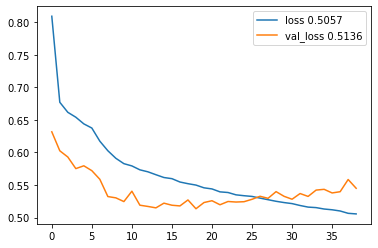

In [91]:
model = train_model([8, 8, 16, 16], [16])
model.save('model_small.hdf')

In [75]:
raise

RuntimeError: No active exception to reraise

## Visualizing agent play

In [93]:
model = load_model('model_medium.hdf')

W0718 20:38:28.613249 140162927552320 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 20:38:28.614795 140162927552320 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [94]:
class Agent():
    def __init__(self, model):
        self._n_rotations = 0
        self.model = model

    def get_action_from_model(self, info):
        frame = info.visual_observations[0][0]
        speed = info.vector_observations.round(2)
        previous_action = info.previous_vector_actions[0]

        model_input = {
            'frame': np.expand_dims(frame, axis=0),
            'speed': speed/10,
        }
        previous_move, previous_rotate = np.zeros(3), np.zeros(3)
        previous_move[int(previous_action[0])] = 1
        previous_rotate[int(previous_action[1])] = 1
        previous_action = np.concatenate([previous_move, previous_rotate])
        model_input['previous_action'] = np.expand_dims(previous_action, axis=0)
        ret = self.model.predict(model_input, batch_size=1)
        action_move = ret[self.model.output_names.index('action_move')]
        action_rotate = ret[self.model.output_names.index('action_rotate')]
        action = [np.argmax(action_move), np.argmax(action_rotate)]
        if action == [0, 0]:
            action = [1, 0]
        if action[0] == 0:
            self._n_rotations += 1
        else:
            self._n_rotations = 0
        if self._n_rotations > 60:
            action = [1, 0]
        return action
    
    def reset(self):
        self._n_rotations = 0

In [95]:
info = env.reset()['Learner']
level_idx = 0
n_steps = 0
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
agent = Agent(model)

while 1:
    frame = info.visual_observations[0][0]
    speed = info.vector_observations.round(2)
    previous_action = info.previous_vector_actions[0]
    
    cv2.imshow('img', frame[:, :, [2, 1, 0]])
    msg = 'Level: %i     n_steps: %i   Reward: %.2f   Speed: %s Text observations: %s' % (
        level_idx,
        n_steps,
        info.rewards[0],
        speed,
        info.text_observations[0])
    cv2.displayOverlay('img', msg)
    key = cv2.waitKey(1)
    if key == ord('o'):
        break
    action = agent.get_action_from_model(info)
    
    info = env.step(vector_action=action)['Learner']
    n_steps += 1
    is_level_ended = info.max_reached[0] or info.local_done[0]
    if is_level_ended:
        level_idx += 1
        n_steps = 0
        agent.reset()
        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

I think that collection of goals has worsened, hopefully it will improve in other categories.

## Summary

I have verified that I can train on mirrored games or train using both sides of the mirror. The model trained with both sides seems to be better at least on the visualizations.

I have trained a new model on more levels